# Satellite data demo

> **Note**: If you wish to save this notebook with any of your changes, please make sure to click on `File` -> `Save a copy in Drive`. All changes will be lost if you close this tab without saving a copy in your Google Drive. All changes made before saving a copy in Drive will be saved in the notebook after you save a copy in Drive. Data is downloaded from the internet and stored in the temporary disk of the environment. This data will be deleted once the session is over.

This demonstration will show you a few key concepts about satellite data and how it can be prepared for featurization. The notebook will guide you through the process of preparing imagery, including:

1. Loading satellite imagery

1. Inspecting image properties

1. Image normalization

1. Image visualization

This notebook will not cover the featurization process. Featurization will be covered in later chapters of the training manual and in demonstration notebooks dedicated to it.

## Environment setup

### Install required packages

Google Colab is a free Jupyter notebook environment that requires no setup and runs entirely in the cloud. It comes preinstalled with many packages, including most of the ones we need for this notebook. There are a few additional packages we need to install, which we will do in the next cell.


In [1]:
# !pip install rasterio
# !pip install exactextract
# !pip install mapclassify

### Load required packages

Now that we have all of the packages we need, we can load all the ones we will use in this notebook.


In [2]:
import os
import glob
import rasterio
import subprocess
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio.features
import matplotlib.pyplot as plt


from tqdm import tqdm
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.merge import merge
from rasterio.io import MemoryFile
from scipy.signal import convolve2d
from exactextract import exact_extract
from matplotlib.patches import Rectangle
from shapely.geometry import box, Polygon, MultiPolygon, GeometryCollection

## Download the ADM0 dataset

In the following example, we create a grid for a GeoDataFrame with a geometry column. The grid will be created for the bounding box of each row, and then cropped to the geometry of that row. First, we load an example of a GeoDataFrame with a geometry column, two countries in this case. We then create a grid for each country and visualize the grid for each country.

This is slightly more practical use case, as it allows for the creation of a grid for multiple locations at once, while still minimizing the number of grid points that are created.


In [91]:
adm_url = "https://github.com/wmgeolab/geoBoundaries/raw/9469f09/releaseData/gbOpen"

tgo_adm0_fp = f"{adm_url}/TGO/ADM0/geoBoundaries-TGO-ADM0.geojson"

tgo_gdf = gpd.read_file(tgo_adm0_fp)

print(f"Object type: {type(tgo_gdf)}")

print(f"CRS: {tgo_gdf.crs}")

print(f"Shape (row, col): {tgo_gdf.shape}")

tgo_gdf[["shapeType", "shapeISO", "shapeName", "geometry"]]

Object type: <class 'geopandas.geodataframe.GeoDataFrame'>
CRS: EPSG:4326
Shape (row, col): (1, 6)


shapeType shapeISO shapeName  \
0      ADM0      TGO      Togo   

                                            geometry  
0  POLYGON ((-0.12366 11.137, -0.1309 11.13846, -...

## Download satellite images

### Data source

This demonstration uses satellite data from Norway's International Climate and Forest Initiative (NICFI) [Satellite Data Program](https://www.planet.com/nicfi/). This program provides access to Planet Labs high-resolution, analysis-ready mosaics of the world’s tropics. This data is made freely available and the terms of use are provided in their [license agreement](https://university.planet.com/nicfi-resources/1219786)

> More details can be found in the [NICFI User Guide](https://assets.planet.com/docs/NICFI_UserGuidesFAQ.pdf)

This data has already gone extensive pre-processing before being released to the public. This includes normalizing pixel values, masking out cloud, and generating basemaps with coverage in the tropics (+/- 30 degrees of latitude). 

### Data products

The NICFI imagery we downloaded includes the same 9 quads from 2 different processing levels. The first level is the "visual" level which is a simple RGB image. The second level is the "analytic" level which includes the RGB and NIR bands.  

To help you understand the differences between the two products, here are some quotes from the [NICFI User Guide](https://assets.planet.com/docs/NICFI_UserGuidesFAQ.pdf):

> **PlanetScope Visual Mosaics**:   
> Optimized for visual display and interpretation, Visual Mosaics offer a “true-colour” representation of spatially accurate data with minimized haze, illumination, and topographic effects. These are ideal for users visually monitoring and interpreting satellite imagery.
>
> **PlanetScope Surface Reflectance Mosaics (Analysis Ready)**:   
> Optimized for scientific and quantitative analysis, these mosaics offer an analytic or “ground truth” representation of spatially accurate data with minimized effects of atmosphere and sensor characteristics. These include a fourth band (near-infrared) and are suited for a variety of vegetation indices, including Normalized Difference Vegetation Index (NDVI), and more. These are ideal for users scientifically or quantitatively monitoring or interpreting satellite imagery.

The visual imagery comes as unsigned 8-bit integers with values ranging from 0 to 255. The analytic imagery comes as 16-bit unsigned integers with values ranging from 0 to 10,000. 

### Data download

For ease of use here, we have limited the basemaps to 9 quads which form a 3x3 grid over Lomé, Togo. We use the same location but different processing levels to show the differences between the two. Both data sets are from the monthly products for December of 2024.

This download will pull a zip file from Zenodo and unpack these images into your data directory. 

In [310]:
# Update when data is available
data_dir = "nicfi_data"

file = "basemaps.zip"
url = f"https://zenodo.org/record/14635861/files/{file}"
local_zip = f"{data_dir}/{file}"
local_dir = local_zip.replace(".zip", "")

os.makedirs(data_dir, exist_ok=True)

if not os.path.exists(local_dir):
    !wget -O {local_zip} {url}

    !unzip {local_zip} -d {data_dir}

    !rm {local_zip}

!ls -lhR {data_dir}

--2025-01-12 18:49:53--  https://zenodo.org/record/14635861/files/basemaps.zip
Resolving zenodo.org (zenodo.org)... 188.185.45.92, 188.185.43.25, 188.185.48.194
Connecting to zenodo.org (zenodo.org)|188.185.45.92|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/14635861/files/basemaps.zip [following]
--2025-01-12 18:49:54--  https://zenodo.org/records/14635861/files/basemaps.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1343466775 (1.3G) [application/octet-stream]
Saving to: ‘nicfi_data/basemaps.zip’

nicfi_data/basemaps 100%[===================>]   1.25G  6.93MB/s    in 3m 46s  

2025-01-12 18:53:41 (5.66 MB/s) - ‘nicfi_data/basemaps.zip’ saved [1343466775/1343466775]

Archive:  nicfi_data/basemaps.zip
replace nicfi_data/basemaps/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
total 0
drwxr-xr-x@ 3 cullenmolitor  staff    96B Jan 12 18:05 __MACOSX
drwxr-xr-x@ 5 cullenmoli

## Load a satellite image

### Listing the images

Now that we have the satellite images in our data directory, lets load and inspect an image at random. We set a random seed for reproducibility. You can manipulate the `seed` value to get a new image, or you can choose from the `image_list` to load a specific image.

The first thing we will do is define the directory with the images and list the images in that directory. We will then load a randdom image in the list and inspect its properties.

Then we will demonstrate several common ways of opening and inspecting the image properties and pixel values.

In [287]:
visual = True
seed = 456
np.random.seed(seed)

if visual:
    mosaic = "planet_medres_normalized_visual_2024-12_mosaic"
else:
    mosaic = "planet_medres_normalized_analytic_2024-12_mosaic"

image_dir = os.path.join(local_dir, mosaic)

image = str(np.random.choice(os.listdir(image_dir)))

# image = '1033-1062_quad.tif'

image_path = os.path.join(image_dir, image)

image_path

'nicfi_data/basemaps/planet_medres_normalized_visual_2024-12_mosaic/1033-1060_quad.tif'

### Load the image with `rasterio`

Rasterio is a Python library designed for reading and writing geospatial raster data. It provides a simple interface to work with raster formats using GDAL under the hood. Rasterio is particularly well-suited for workflows that involve accessing, inspecting, and manipulating individual raster files, such as georeferencing or clipping to specific extents. Its lightweight nature and focus on file-based operations make it a great choice for users needing precise control over raster data processing, especially for small to medium-sized datasets. 

In [302]:
import rasterio

with rasterio.open(image_path) as src:
    rast = src.read([1, 2, 3])

print(f"""
Shape: {rast.shape}
CRS: {src.crs}
Driver: {src.driver}
Data type: {src.dtypes[0]}
Dataset name: {src.name}
Bounds: {src.bounds}
Data sample: 
{rast[:1]}
""")


Shape: (3, 4096, 4096)
CRS: EPSG:3857
Driver: GTiff
Data type: uint8
Dataset name: nicfi_data/basemaps/planet_medres_normalized_visual_2024-12_mosaic/1033-1060_quad.tif
Bounds: BoundingBox(left=176110.91315084323, bottom=704443.6525846027, right=195678.7923891306, top=724011.53182289)
Data sample: 
[[[ 99 111 115 ...  43  48  41]
  [105 111 115 ...  48  51  47]
  [113 113 107 ...  50  49  49]
  ...
  [ 54  56  53 ...  48  50  54]
  [ 54  57  54 ...  45  48  53]
  [ 54  54  52 ...  45  50  50]]]



### Load the image with `xarray`

Xarray is a versatile library designed for handling multi-dimensional labeled datasets. While it is not specific to geospatial data, it excels at working with datasets that have multiple dimensions, such as time, latitude, and longitude. Xarray's core strength lies in its ability to handle large datasets efficiently with lazy loading and parallel processing, particularly when combined with Dask. It is ideal for users working with complex spatiotemporal datasets or datasets requiring advanced mathematical operations and aggregations across dimensions. 

We are not going to look at much of the meta data with `xarray` because the interface is the same as `rioxarray` and we will use that instead. In general, the commands will be similar.

In [304]:
import xarray as xr

xrds = xr.open_dataset(image_path)
xrds

<xarray.Dataset> Size: 269MB
Dimensions:      (band: 4, x: 4096, y: 4096)
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 33kB 1.761e+05 1.761e+05 ... 1.957e+05 1.957e+05
  * y            (y) float64 33kB 7.24e+05 7.24e+05 ... 7.045e+05 7.044e+05
    spatial_ref  int64 8B ...
Data variables:
    band_data    (band, y, x) float32 268MB ...

### Load the image with `rioxarray`

Rioxarray builds on `Xarray`, adding geospatial capabilities to its powerful data handling. It integrates `Rasterio`'s geospatial functionality with `Xarray`'s multi-dimensional data structures, making it a comprehensive tool for geospatial raster analysis. `Rioxarray` is perfect for users who need to work with geospatially-aware raster data while leveraging `Xarray`'s capabilities for advanced analysis and scalability. It is an excellent choice when combining geospatial operations with multi-dimensional data workflows, especially for large-scale analysis.

In the code below we use this library to open the image and inspect its properties.

In [306]:
import rioxarray

rxrds = rioxarray.open_rasterio(image_path)
rxrds

<xarray.DataArray (band: 4, y: 4096, x: 4096)> Size: 67MB
[67108864 values with dtype=uint8]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 33kB 1.761e+05 1.761e+05 ... 1.957e+05 1.957e+05
  * y            (y) float64 33kB 7.24e+05 7.24e+05 ... 7.045e+05 7.044e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

We can see that the image has 4 bands, each with 238x234 pixels. The image not contain any other spatial information, such as a coordinate reference system or a transform. This is because the image was clipped from larger basemap quads (which did have such information) and to save space, we cut the 5th band and the spatial information. 

Instead we rely on the file name which has a unique grid location identifier. This identifier has the latitude and longitude embedded in it. This lat/lon is the center of the grid cell and therefore the center of the image. If you have access to more storage and memory, it would be best practice to update the image chip with the spatial information from the original basemap.

We can access the pixel values of the image using the `data` attribute. This returns a `numpy` array with the pixel values. To limit what is returned for inspection, we will subset the data array with `[:1]`

In [308]:
rxrds.data[:1]

array([[[ 99, 111, 115, ...,  43,  48,  41],
        [105, 111, 115, ...,  48,  51,  47],
        [113, 113, 107, ...,  50,  49,  49],
        ...,
        [ 54,  56,  53, ...,  48,  50,  54],
        [ 54,  57,  54, ...,  45,  48,  53],
        [ 54,  54,  52, ...,  45,  50,  50]]], dtype=uint8)

We can also access the pixel values of a specific band using the `sel` method. This method allows us to select a specific band using the band name or index. In this case, we select the red band using the band name.

In [309]:
rxrds.sel(band=1)

<xarray.DataArray (y: 4096, x: 4096)> Size: 17MB
array([[ 99, 111, 115, ...,  43,  48,  41],
       [105, 111, 115, ...,  48,  51,  47],
       [113, 113, 107, ...,  50,  49,  49],
       ...,
       [ 54,  56,  53, ...,  48,  50,  54],
       [ 54,  57,  54, ...,  45,  48,  53],
       [ 54,  54,  52, ...,  45,  50,  50]], dtype=uint8)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 33kB 1.761e+05 1.761e+05 ... 1.957e+05 1.957e+05
  * y            (y) float64 33kB 7.24e+05 7.24e+05 ... 7.045e+05 7.044e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

### Why Choose One Over the Other?

- Use `Rasterio` for simple, file-level operations and when you need direct control over geospatial data manipulation.
- Choose `Xarray` for working with multi-dimensional data without geospatial metadata or when performing complex mathematical operations across dimensions.
- Opt for `Rioxarray` when you need a blend of geospatial metadata management and multi-dimensional analysis, especially for scalable workflows with large datasets.

## Visualize the image

### Overview



### The four bands of NICFI imagery

Four our basic visualizations and manipulations we will use `rasterio`. The first thing we will look at is each of the four bands to get a sense of the shape of the image, the structures it depicts, and the scale of the color values.

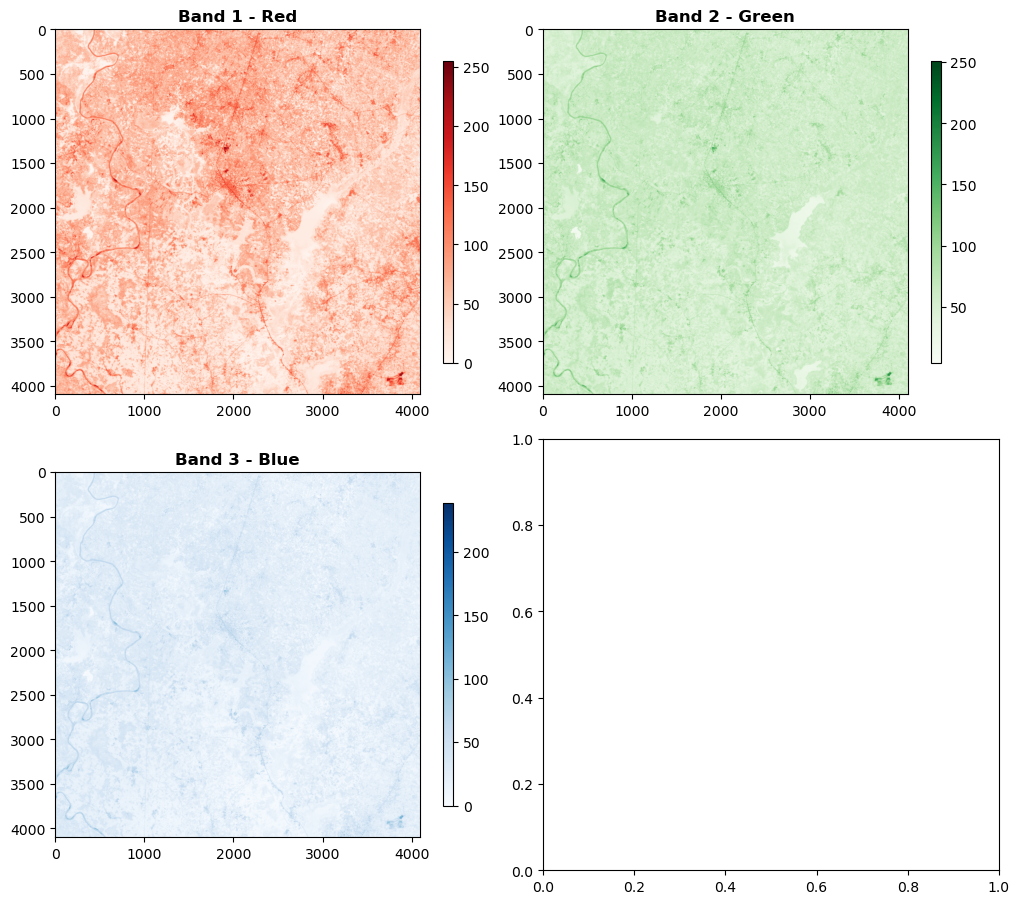

In [267]:
# Open the image file
with rasterio.open(image_path) as src:
    # Read all four bands
    band1 = src.read(1)  # Red
    band2 = src.read(2)  # Green
    band3 = src.read(3)  # Blue
    # band4 = src.read(4)  # NIR

    # band1 = gamma_correction(band1, gamma)
        # Apply visualization to each band
    # band1 = apply_visualization(band1, min_val, max_val, gamma)
    # band2 = apply_visualization(band2, min_val, max_val, gamma)
    # band3 = apply_visualization(band3, min_val, max_val, gamma)
    # band4 = apply_visualization(band4, min_val, max_val, gamma)

    # Adjust figure size and spacing
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 9))
    plt.subplots_adjust(wspace=0.0, hspace=0.0)  # Adjust spacing between subplots

    im1 = show(band1, ax=ax1, title="Band 1 - Red", cmap="Reds")
    plt.colorbar(im1.get_images()[0], ax=ax1, shrink=0.7, aspect=30)

    im2 = show(band2, ax=ax2, title="Band 2 - Green", cmap="Greens")
    plt.colorbar(im2.get_images()[0], ax=ax2, shrink=0.7, aspect=30)

    im3 = show(band3, ax=ax3, title="Band 3 - Blue", cmap="Blues")
    plt.colorbar(im3.get_images()[0], ax=ax3, shrink=0.7, aspect=30)

    # im4 = show(band4, ax=ax4, title="Band 4 - Near-Infrared", cmap="viridis")
    # plt.colorbar(im4.get_images()[0], ax=ax4, shrink=0.7, aspect=30)

    # Adjust layout with specified padding
    plt.tight_layout(pad=0.0)
    plt.show()

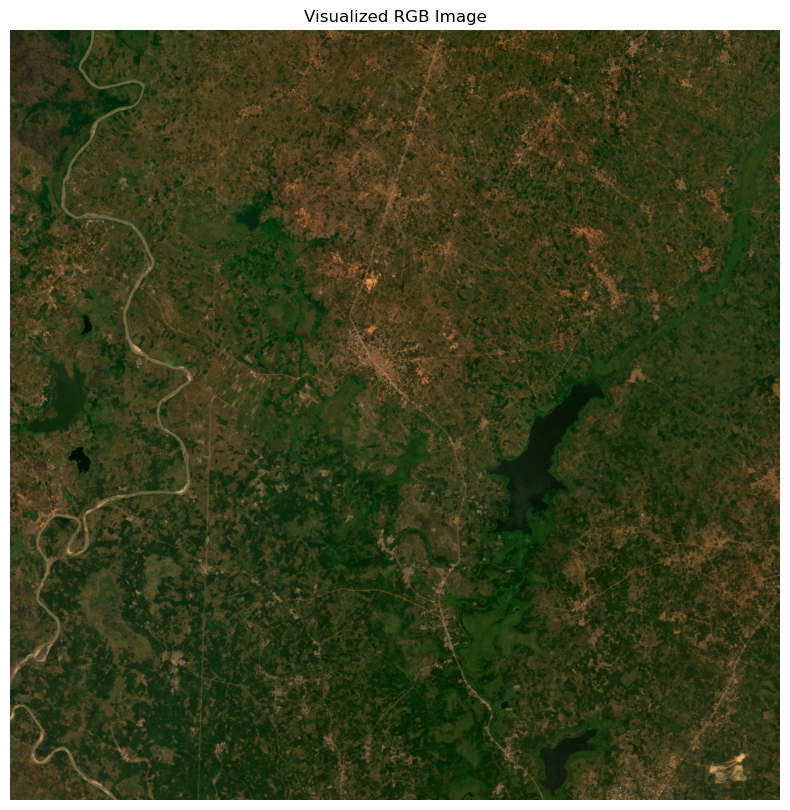

In [268]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Define visualization parameters
min_val = 64
max_val = 5454
gamma = 1.8

# Function to apply min-max scaling and gamma correction
def apply_visualization(band, min_val, max_val, gamma):
    # Clip the values to the min-max range
    band_clipped = np.clip(band, min_val, max_val)
    # Normalize the values to 0-1
    band_normalized = (band_clipped - min_val) / (max_val - min_val)
    # Apply gamma correction
    band_gamma_corrected = np.power(band_normalized, 1 / gamma)
    return band_gamma_corrected

# Open the image and read the bands
with rasterio.open(image_path) as src:
    band1 = src.read(1)  # Red
    band2 = src.read(2)  # Green
    band3 = src.read(3)  # Blue

    # Apply visualization to each band
    # band1 = apply_visualization(band1, min_val, max_val, gamma)
    # band2 = apply_visualization(band2, min_val, max_val, gamma)
    # band3 = apply_visualization(band3, min_val, max_val, gamma)

    # Stack the bands for an RGB image
    rgb_image = np.stack([band1, band2, band3], axis=-1)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_image)
plt.axis('off')
plt.title('Visualized RGB Image')
plt.show()


### Visualize the image 

#### Image normalization

In the above section, we see that the pixel values in the image are between 0 and 10,000. This is a common range for satellite imagery, as it allows for a wide range of values to be captured. However, these values can need to be transformed before they can visualized or used in machine learning models.

> Reading recommendation: [Revisiting pre-trained remote sensing model benchmarks: resizing and normalization matters](https://arxiv.org/abs/2305.13456)

In this section we will look at the same image, but this time we will normalize the pixel values to be between 0 and 1. This is a common preprocessing step when working with images, as it can help improve the performance and speed of machine learning models. 

In this first pass, we take a simplistic method of normalizing the pixel values. There are numerous ways to accomplish image normalization, and we have seen that what you choose could have a downstream impact on the performance of your final MOSAIKS model.

In this case, we normalize the pixel values for each band independently, using the minimum and maximum pixel values for each band. The calculation is as follows: 

$$normalized = \frac{pixel - min}{max - min}$$

Where min is the minimum pixel value in the band and max is the maximum pixel value in the band. The new array `normalized` will have pixel values between 0 and 1. We repeat this for every band in the image.

There are many common methods for normalizing images, and the best method will depend on the specific use case. For example, you may want to normalize the pixel values to have a mean of 0 and a standard deviation of 1. In this case you would use the following calculation:

$$normalized = \frac{pixel - mean}{std}$$

Where mean is the mean pixel value in the band and std is the standard deviation of the pixel values in the band.

You are also able to normalize the pixel values across all bands, rather than independently for each band. This can be useful if you want to compare the pixel values across bands (i.e. you expect your outcome to be influenced by the relative values of the bands, rather than the absolute values).

Finally, it is common to draw the min, max, or mean values for each band across all images in your dataset. This can help you understand the range of pixel values in your dataset and identify any outliers or anomalies. Due to extreme values it can be a good idea to use a percentile based normalization, where you normalize the pixel values to be between the 1st and 99th percentile of the pixel values in the band.

#### Visualize the normalized image

This is just a starting point for normalizing images, and you may need to experiment with different methods to find the best one for your specific use case. For now, lets use the simple method of normalizing the pixel values to be between 0 and 1.

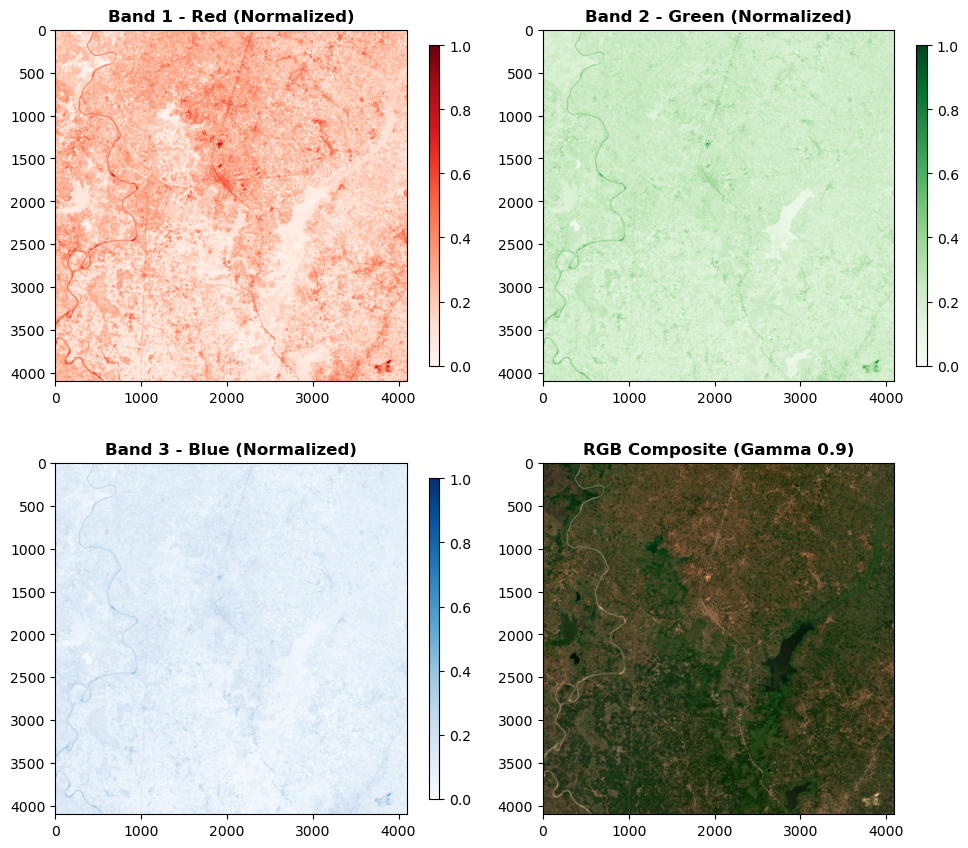

In [245]:
# Define a gamma correction function
def gamma_correction(image, gamma):
    return np.power(image, gamma)

# Open the image file
with rasterio.open(image_path) as src:
    # Read and normalize each band independently
    band1 = src.read(1)  # Red
    band2 = src.read(2)  # Green
    band3 = src.read(3)  # Blue

    # Normalize each band independently
    norm_band1 = (band1 - band1.min()) / (band1.max() - band1.min())
    norm_band2 = (band2 - band2.min()) / (band2.max() - band2.min())
    norm_band3 = (band3 - band3.min()) / (band3.max() - band3.min())

    # Create RGB composite from normalized bands
    rgb = np.dstack((norm_band1, norm_band2, norm_band3))

    # Apply gamma correction to the RGB composite
    gamma = .9  # Change this value to adjust brightness
    rgb_corrected = gamma_correction(rgb, gamma)

    # Create the figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8.8))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Plot individual bands using normalized data
    im1 = show(norm_band1, ax=ax1, title="Band 1 - Red (Normalized)", cmap="Reds")
    plt.colorbar(im1.get_images()[0], ax=ax1, shrink=0.8, aspect=30)

    im2 = show(norm_band2, ax=ax2, title="Band 2 - Green (Normalized)", cmap="Greens")
    plt.colorbar(im2.get_images()[0], ax=ax2, shrink=0.8, aspect=30)

    im3 = show(norm_band3, ax=ax3, title="Band 3 - Blue (Normalized)", cmap="Blues")
    plt.colorbar(im3.get_images()[0], ax=ax3, shrink=0.8, aspect=30)

    # Plot gamma-corrected RGB composite
    im4 = ax4.imshow(rgb_corrected)
    ax4.set_title(f"RGB Composite (Gamma {gamma})", fontweight="bold")
    ax4.axis("on")
    # Add invisible colorbar
    cbar = plt.colorbar(im4, ax=ax4, shrink=0.8, aspect=30)
    cbar.ax.set_visible(False)

    plt.tight_layout(pad=1.0)
    plt.show()


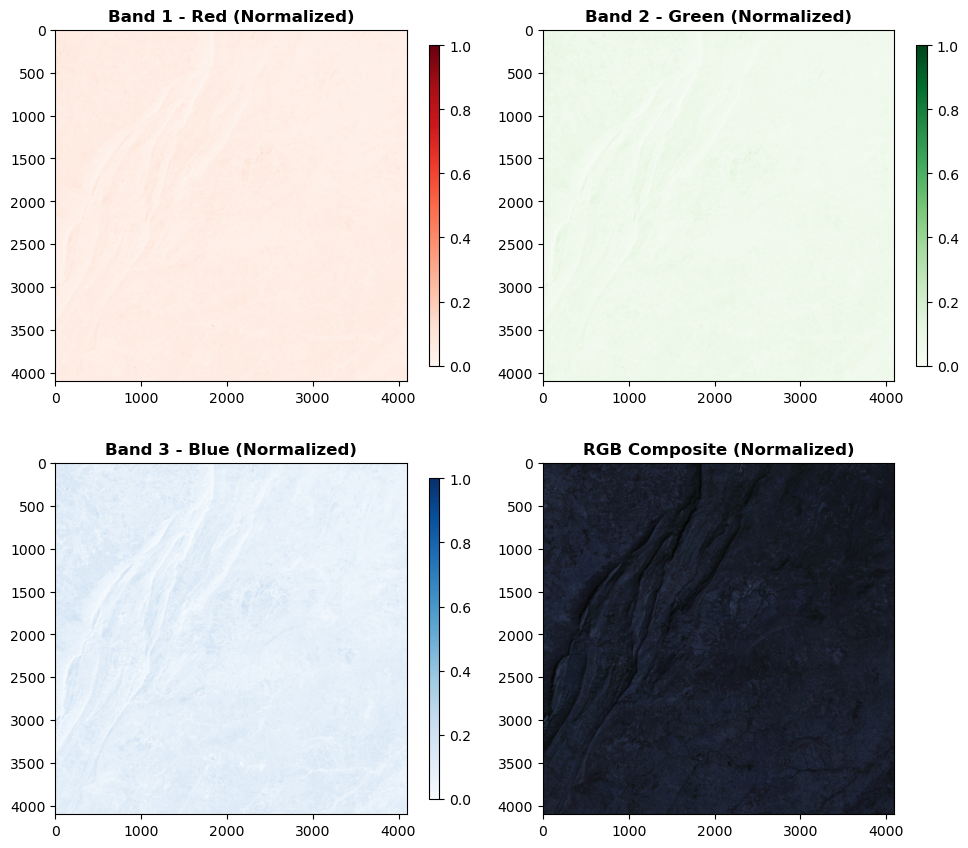

In [155]:
# Open the image file
with rasterio.open(image_path) as src:
    # Read and normalize each band independently
    band1 = src.read(1)  # Red
    band2 = src.read(2)  # Green
    band3 = src.read(3)  # Blue

    # Normalize each band independently
    norm_band1 = (band1 - band1.min()) / (band1.max() - band1.min())
    norm_band2 = (band2 - band2.min()) / (band2.max() - band2.min())
    norm_band3 = (band3 - band3.min()) / (band3.max() - band3.min())

    # Create RGB composite from normalized bands
    rgb = np.dstack((norm_band1, norm_band2, norm_band3))
    gamma = .75  # Change this value to adjust brightness
    rgb = gamma_correction(rgb, gamma)
    # Create the figure
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8.8))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Plot individual bands using normalized data
    im1 = show(norm_band1, ax=ax1, title="Band 1 - Red (Normalized)", cmap="Reds")
    plt.colorbar(im1.get_images()[0], ax=ax1, shrink=0.8, aspect=30)

    im2 = show(norm_band2, ax=ax2, title="Band 2 - Green (Normalized)", cmap="Greens")
    plt.colorbar(im2.get_images()[0], ax=ax2, shrink=0.8, aspect=30)

    im3 = show(norm_band3, ax=ax3, title="Band 3 - Blue (Normalized)", cmap="Blues")
    plt.colorbar(im3.get_images()[0], ax=ax3, shrink=0.8, aspect=30)

    # Plot RGB composite
    im4 = ax4.imshow(rgb)
    ax4.set_title("RGB Composite (Normalized)", fontweight="bold")
    ax4.axis("on")
    # Add invisible colorbar
    cbar = plt.colorbar(im4, ax=ax4, shrink=0.8, aspect=30)
    cbar.ax.set_visible(False)

    plt.tight_layout(pad=1.0)
    plt.show()

#### Other normalization methods

Z-score, max, percentile. Placeholder


In [139]:
#### Placeholder

### Sharpen the image

We can see the image is a bit blury. This is common in satellite imagery, as the images are often taken from a distance and can be affected by atmospheric conditions. One way to improve the sharpness of the image is to apply a sharpening filter. This is a common technique in image processing, and can help to bring out the details in the image.

We will apply a sharpening filter to the image, then we will visualize the input image, the sharpened image, and the difference between the two as a map and as a histogram.

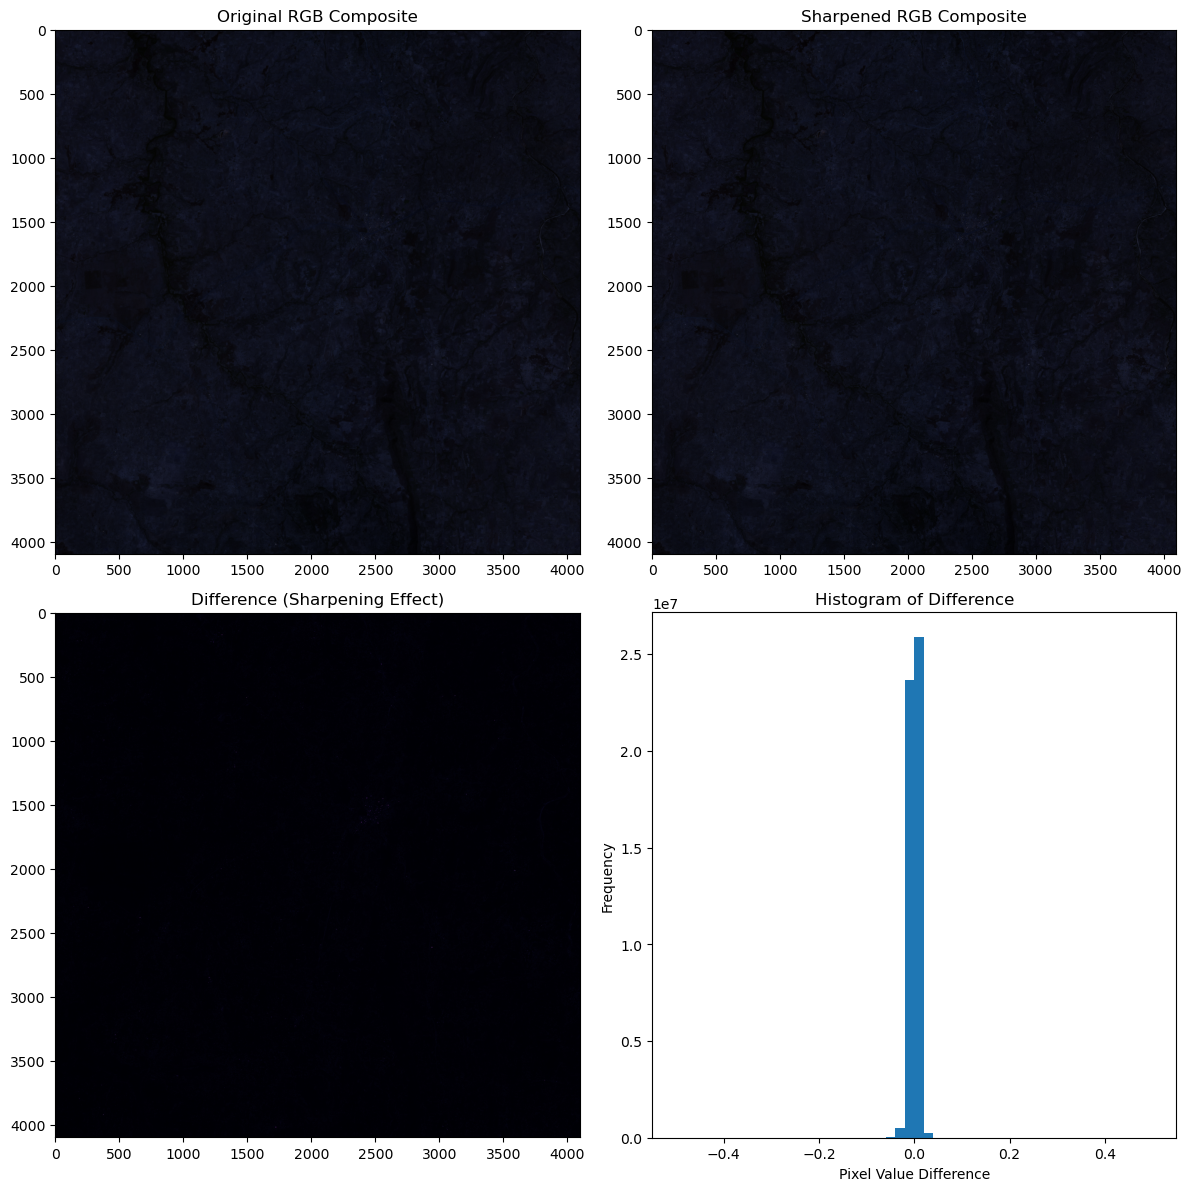

In [140]:
def sharpen_image(image):
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    # Apply kernel to each band
    if len(image.shape) == 3:
        sharpened = np.zeros_like(image)
        for i in range(image.shape[2]):
            sharpened[:, :, i] = convolve2d(
                image[:, :, i], kernel, mode="same", boundary="symm"
            )
    else:
        sharpened = convolve2d(image, kernel, mode="same", boundary="symm")

    return np.clip(sharpened, 0, 1)


with rasterio.open(image_path) as src:
    # Read each band
    band1 = src.read(1)  # Red
    band2 = src.read(2)  # Green
    band3 = src.read(3)  # Blue

    # Normalize each band indendently
    norm_band1 = (band1 - band1.min()) / (band1.max() - band1.min())
    norm_band2 = (band2 - band2.min()) / (band2.max() - band2.min())
    norm_band3 = (band3 - band3.min()) / (band3.max() - band3.min())

    # Create RGB composite from normalized bands
    rgb = np.dstack((norm_band1, norm_band2, norm_band3))

    # Create sharpened version
    rgb_sharpened = sharpen_image(rgb)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    # Plot original RGB composite
    ax1.imshow(rgb)
    ax1.set_title("Original RGB Composite")
    ax1.axis("on")

    # Plot sharpened RGB composite
    ax2.imshow(rgb_sharpened)
    ax2.set_title("Sharpened RGB Composite")
    ax2.axis("on")

    # Plot difference between original and sharpened
    difference = rgb_sharpened - rgb

    # ax3.imshow(np.abs(difference), cmap="magma")

    # mean_difference = np.mean(difference, axis=2)
    # ax3.imshow(mean_difference, cmap='magma', vmin=-0.2, vmax=0.2)

    # rms_difference = np.sqrt(np.mean(difference**2, axis=2))
    # ax3.imshow(rms_difference, cmap='magma')

    magnitude_difference = np.sqrt(np.sum(difference**2, axis=2))
    ax3.imshow(magnitude_difference, cmap="magma")

    ax3.set_title("Difference (Sharpening Effect)")
    ax3.axis("on")

    # Plot histogram of difference
    ax4.hist(difference.ravel(), bins=50, range=(-0.5, 0.5))
    ax4.set_title("Histogram of Difference")
    ax4.set_xlabel("Pixel Value Difference")
    ax4.set_ylabel("Frequency")

    plt.tight_layout(pad=1.0)
    plt.show()

## Derivative products

### Normalized Difference Vegetation Index (NDVI) 

The Normalized Difference Vegetation Index (NDVI) is a metric used to measure the health and density of vegetation. It's calculated by comparing the amount of visible and near-infrared light reflected by vegetation. The formula for calculating NDVI is:

$$NDVI = \frac{NIR - Red}{NIR + Red}$$

Where NIR is the near-infrared band and Red is the red band. The resulting NDVI values range from -1 to 1, with higher values indicating denser, healthier vegetation. Negative values typically represent water or other non-vegetated surfaces, while values close to zero represent barren land or urban areas.

> A helpful guide for calculating NDVI can be found [here](https://developers.planet.com/docs/planetschool/calculate-an-ndvi-in-python/)

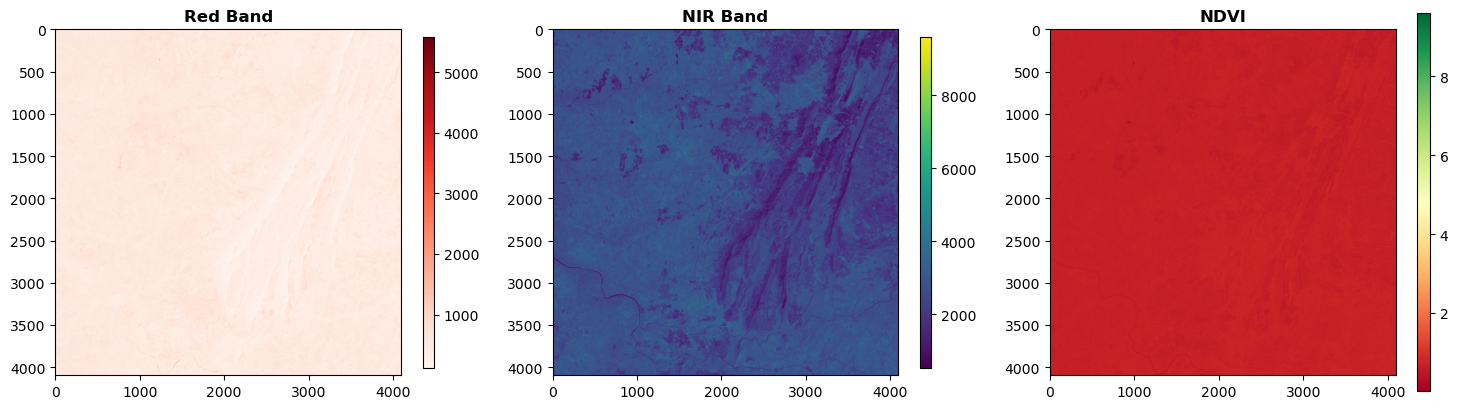

In [126]:
# Open the image file
with rasterio.open(image_path) as src:
    # Read the red and NIR bands
    red = src.read(1)  # Red
    nir = src.read(4)  # NIR

    # Calculate NDVI using raw values
    ndvi = (nir - red) / (nir + red + 1e-10)

    # Normalize bands only for display purposes
    norm_red = (red - red.min()) / (red.max() - red.min())
    norm_nir = (nir - nir.min()) / (nir.max() - nir.min())

    # Create the figure with three panels
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    plt.subplots_adjust(wspace=0.3)

    # Plot Red band
    im1 = show(red, ax=ax1, title="Red Band", cmap="Reds")
    plt.colorbar(im1.get_images()[0], ax=ax1, shrink=0.7, aspect=30)

    # Plot NIR band
    im2 = show(nir, ax=ax2, title="NIR Band", cmap="viridis")
    plt.colorbar(im2.get_images()[0], ax=ax2, shrink=0.7, aspect=30)

    # Plot NDVI
    im3 = ax3.imshow(ndvi, cmap="RdYlGn")
    ax3.set_title("NDVI", fontweight="bold")
    plt.colorbar(im3, ax=ax3, shrink=0.8, aspect=30)

    plt.tight_layout(pad=1.0)
    plt.show()

### Enhanced Vegetation Index (EVI)

Optional, repeat the same process for the Enhanced Vegetation Index (EVI). 

The Enhanced Vegetation Index (EVI) is similar to Normalized Difference Vegetation Index (NDVI) and can be used to quantify vegetation greenness. However, EVI corrects for some atmospheric conditions and canopy background noise and is more sensitive in areas with dense vegetation. It incorporates an “L” value to adjust for canopy background, “C” values as coefficients for atmospheric resistance, and values from the blue band (B).  These enhancements allow for index calculation as a ratio between the R and NIR values, while reducing the background noise, atmospheric noise, and saturation in most cases. The formula for calculating EVI is:

$$EVI = G \times \frac{NIR - Red}{NIR + C1 \times Red - C2 \times Blue + L}$$

Where NIR is the near-infrared band, Red is the red band, Blue is the blue band, and G, C1, C2, and L are constants. The resulting EVI values range from -1 to 1, with higher values indicating denser, healthier vegetation. Negative values typically represent water or other non-vegetated surfaces, while values close to zero represent barren land or urban areas.

In [104]:
############################
#### Optional Code here ####
############################


## The distribution of pixel values

Often, image datasets are too large to load into memory all at once. In these cases, it can be helpful to understand the distribution of pixel values in the dataset before loading the images. This can help you identify any outliers or anomalies in the data, and can help you decide how to normalize the pixel values.

In [102]:
base_dir = "/Users/cullenmolitor/Documents/github/MOSAIKS-Training-Manual/notebooks/demo/basemaps"

mosaic_name = "planet_medres_normalized_analytic_2024-12_mosaic"

clipped_images_dir = os.path.join(base_dir, mosaic_name, "clipped_images")

shapes = []

directory = os.path.join(clipped_images_dir)
tif_files = glob.glob(os.path.join(directory, "*.tif"))

for tif_file in tqdm(tif_files, desc="Image chips", unit="file"):
    with rasterio.open(tif_file) as src:
        height = src.height
        width = src.width

        # Read only first 4 bands
        data = src.read(list(range(1, 5)))  # Bands 1-4

        stats = {}
        # Calculate statistics for each band
        for band_idx in range(4):  # Only process 4 bands
            band_data = data[band_idx]
            stats[f"band_{band_idx + 1}_min"] = float(np.min(band_data))
            stats[f"band_{band_idx + 1}_max"] = float(np.max(band_data))
            stats[f"band_{band_idx + 1}_mean"] = float(np.mean(band_data))
            stats[f"band_{band_idx + 1}_median"] = float(np.median(band_data))

    filename = os.path.splitext(os.path.basename(tif_file))[0]
    shapes.append({"filename": filename, "h": height, "w": width, **stats})

Image chips: 100%|██████████| 46599/46599 [02:56<00:00, 264.17file/s]


### Visualize the distribution 

In this plot we look at 4 histograms, one for each statistic we calculate above. Each histogram has 4 colors representing the 4 bands in the image. The histograms show the distribution of pixel values for each band in the image. The x-axis represents the pixel values, and the y-axis represents the number of pixels with that value range.

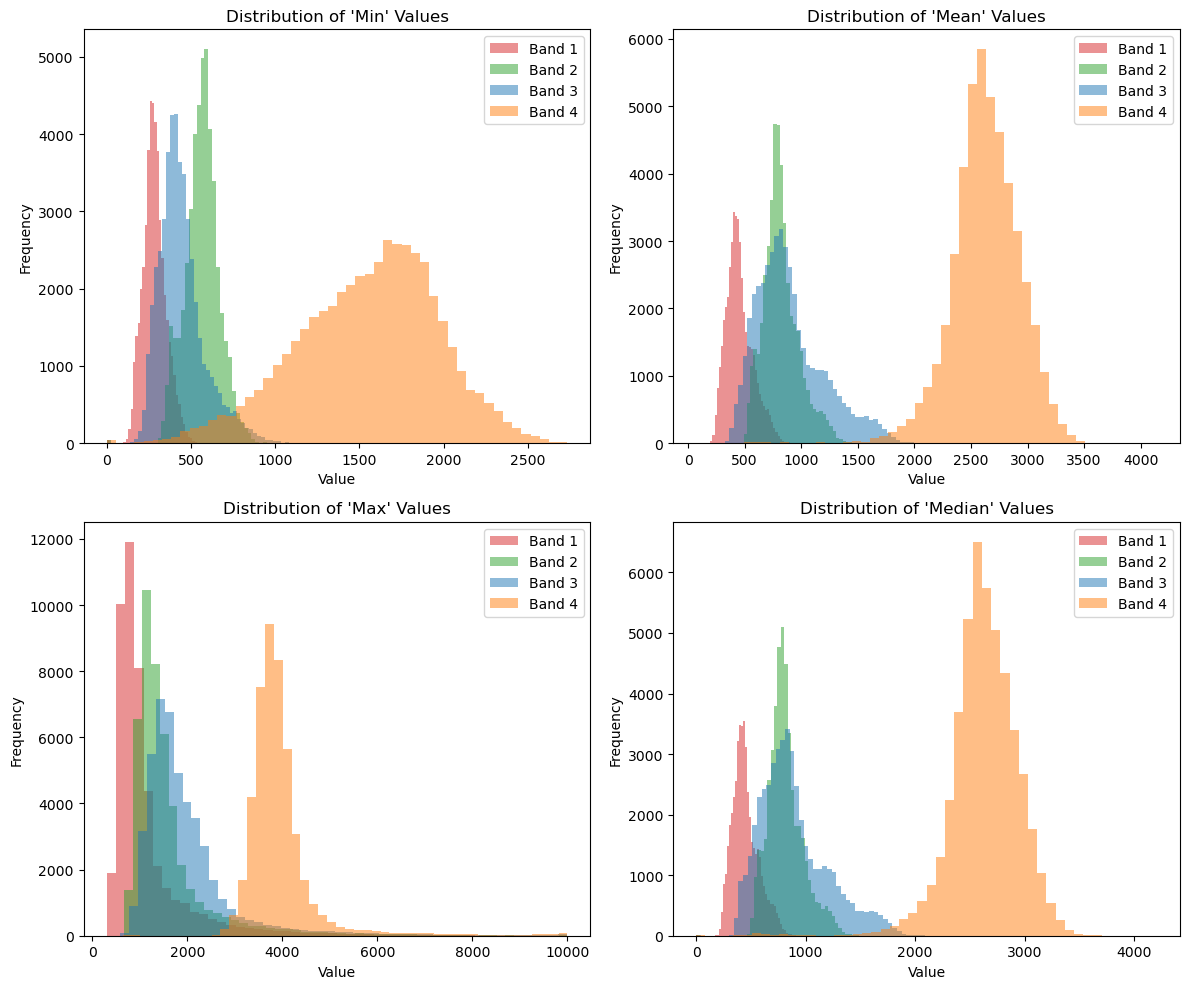

In [108]:
df = pd.DataFrame(shapes)

# Create 2x2 grid of histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

stats_to_plot = [
    "min",
    "mean",
    "max",
    "median",
]
colors = [
    "#d62728",
    "#2ca02c",
    "#1f77b4",
    "#ff7f0e",
]  # Different color for each band

for idx, stat in enumerate(stats_to_plot):
    for band in range(4):
        column = f"band_{band + 1}_{stat}"
        axes[idx].hist(
            df[column], alpha=0.5, color=colors[band], label=f"Band {band + 1}", bins=50
        )

    axes[idx].set_title(f"Distribution of '{stat.capitalize()}' Values")
    axes[idx].set_xlabel("Value")
    axes[idx].set_ylabel("Frequency")
    axes[idx].legend()

plt.tight_layout()
plt.show()

## Resizing the image

In this section we will resize the image to a standard size. This is a common preprocessing step for computer vision tasks, as it can help to improve the performance and speed of machine learning models.

> MOSAIKS does not require that all images be a standard size. If using the torchgeo library, the images will be resized to a standard size but only for the purposes of drawing empirical weights from the images. The original images can be used for training the model.

In this case, we will resize the image to be the mean size of all the images in the dataset. If you wanted to try using pre-built models, you would need to resize the images to the size that the model expects.

In [ ]:
#### Code for resizing images ####